In [69]:
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import StratifiedKFold
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

In [70]:
random_seed = 22

In [71]:
dataset = pd.read_csv('../dataset/recruitment_data.csv', sep=',', decimal='.')
features = list(dataset.columns.values)
target = features.pop(-1)
# dataset.nunique().sort_values() # Check number of unique values

features.remove('Age')
features.remove('Gender')
features.remove('PreviousCompanies')
features.remove('DistanceFromCompany')

corr = dataset.corr()
corr_target = corr['HiringDecision']
corr_target.sort_values(ascending = False)
corr_target

Age                    0.001850
Gender                -0.002249
EducationLevel         0.236710
ExperienceYears        0.122494
PreviousCompanies      0.044025
DistanceFromCompany   -0.016791
InterviewScore         0.146064
SkillScore             0.203668
PersonalityScore       0.169177
RecruitmentStrategy   -0.477552
HiringDecision         1.000000
Name: HiringDecision, dtype: float64

<Axes: ylabel='count'>

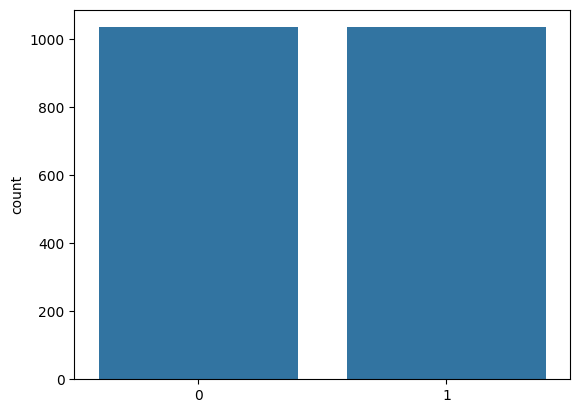

In [72]:
# Apply SMOTE to balance dataset
X = dataset[features].to_numpy()
y = dataset[target].to_numpy()

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
sb.countplot(x=y)

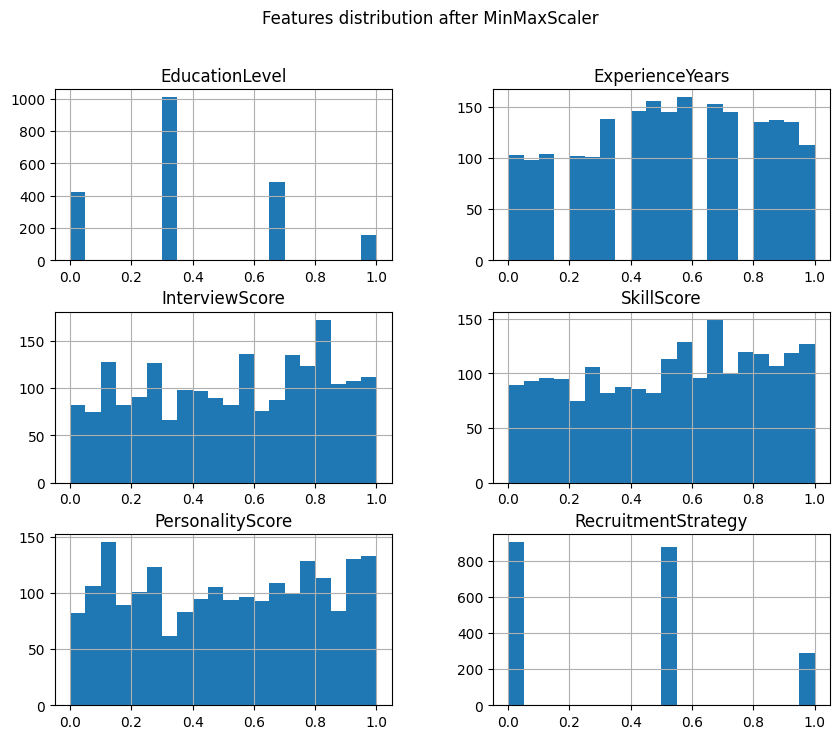

In [73]:
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=features)
X_normalized_df.hist(bins=20, figsize=(10, 8))
plt.suptitle('Features distribution after MinMaxScaler')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
max_neurons = [8,16,24,32]
max_hidden_layers = [8,10,15,20]
f_activation = ['tanh'] # 'tanh', 'relu', 'sigmoid'
metric = 'accuracy' # 'Precision', 'Recall', 'Accuracy'
patience = 500
max_epochs = [5 * patience]
min_improvement = 0.01
adam_initial_learning_rate = [0.001]
adam_learning_rate_decay = 0.99
loss = 'binary_crossentropy'
optimizer = 'adam'
max_cores = -1
validation_split = 0.3

keras.utils.set_random_seed(random_seed)
# Split data into kfolds
sk_folds = StratifiedKFold(n_splits=10)
sk_folds.get_n_splits(X_train_scaled, y)

10

In [75]:
def create_model(neurons, activation, num_layers=1, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Define input shape here
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(neurons, activation=activation),
    ])

    # Adds another layer dynamic
    layer = 1
    if num_layers > layer:
        layer = num_layers
        model.add(tf.keras.layers.Dense(neurons, activation=activation))
        model.add(tf.keras.layers.BatchNormalization())
    # for _ in range(num_layers):
    #     model.add(hidden)
        # model.add(tf.keras.layers.BatchNormalization())

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=adam_learning_rate_decay)
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
    return model

In [76]:
# Create Keras Classifier
model = KerasClassifier(model=create_model, verbose=0)

param_grid = dict(
  epochs=max_epochs,
  model__neurons=max_neurons,
  model__activation=f_activation,
  optimizer=[optimizer],
  # batch_size=[X_train_scaled.shape[0]],
  batch_size=[500],
  optimizer__learning_rate=adam_initial_learning_rate,
  model__num_layers=max_hidden_layers
)

# Setup Grid Search with cross validation
grid = GridSearchCV(
  estimator=model, 
  param_grid=param_grid, 
  cv=sk_folds, 
  verbose=3,
  n_jobs = max_cores,
  return_train_score=True
)

# Early stop callback
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=patience, 
  restore_best_weights=True
)
early_stopping_metric = EarlyStopping(
  monitor = metric,
  mode='max',
  patience=patience,
  min_delta=min_improvement,
  restore_best_weights=True
)

In [77]:
print('TRAINING PROCEDURE STARTED...\n')

# Execute Grid Search
grid_result = grid.fit(
  X_train_scaled, 
  y_train, 
  callbacks=[early_stopping, early_stopping_metric], 
  validation_split=validation_split, 
  # class_weight=class_weights_dict
)

# Best hyperparameter found
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate best model in test set
best_model = grid_result.best_estimator_.model_
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test set loss: {test_loss}, Test set accuracy: {test_accuracy}')

# Get best model in training
history = grid_result.best_estimator_.fit(
  X_train_scaled, 
  y_train, 
  validation_split=validation_split, 
  epochs=grid_result.best_params_['epochs'],
  verbose=0
)

TRAINING PROCEDURE STARTED...

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 3/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.928, test=0.917) total time= 1.2min
[CV 1/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.909, test=0.890) total time= 1.2min
[CV 10/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.919, test=0.882) total time= 1.2min
[CV 9/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=8, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.923, test=0.883) total time= 1.3min
[CV 2/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons

[CV 1/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.928, test=0.883) total time= 1.3min
[CV 2/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.918, test=0.862) total time= 1.3min


[CV 3/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.915, test=0.841) total time= 1.3min


[CV 4/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.921, test=0.883) total time= 1.3min
[CV 5/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.931, test=0.855) total time= 1.3min


[CV 6/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.917, test=0.897) total time= 1.3min


[CV 9/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.934, test=0.903) total time= 1.3min
[CV 8/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.925, test=0.903) total time= 1.3min


[CV 7/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.922, test=0.931) total time= 1.3min


[CV 10/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=15, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.917, test=0.903) total time= 1.3min
[CV 2/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=20, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.915, test=0.883) total time= 1.2min
[CV 1/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=20, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.935, test=0.897) total time= 1.3min
[CV 3/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=20, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.928, test=0.876) total time= 1.3min
[CV 4/10] END batch_size=500, epochs=2500, model__activation=tanh, model__neurons=8, model__num_layers=20, optimizer=adam, optimizer__learning_rate=0.001;, score=(train=0.

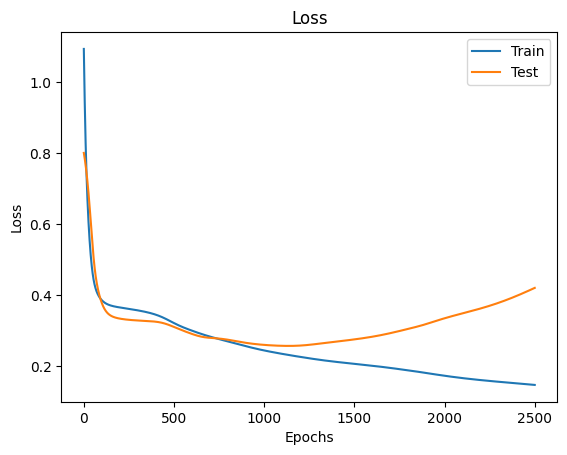

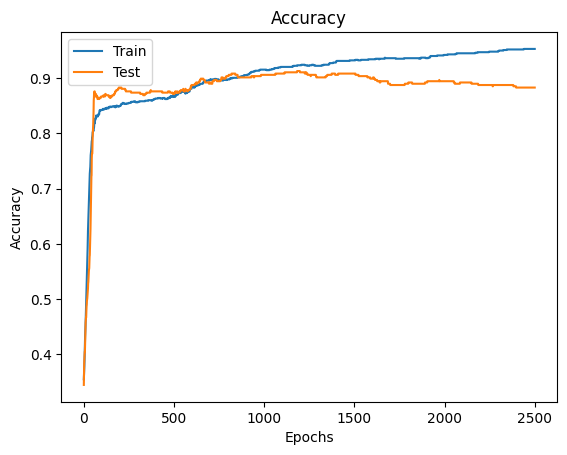

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


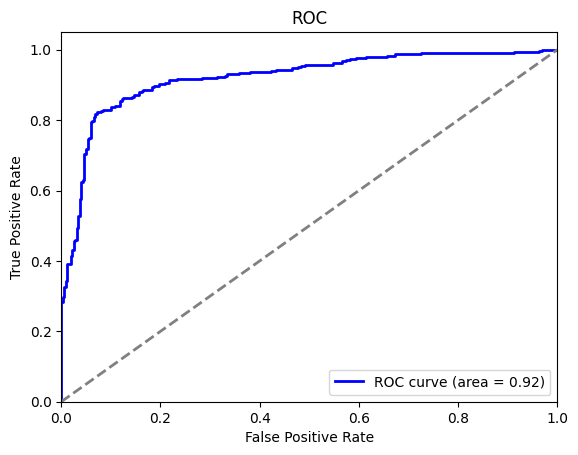

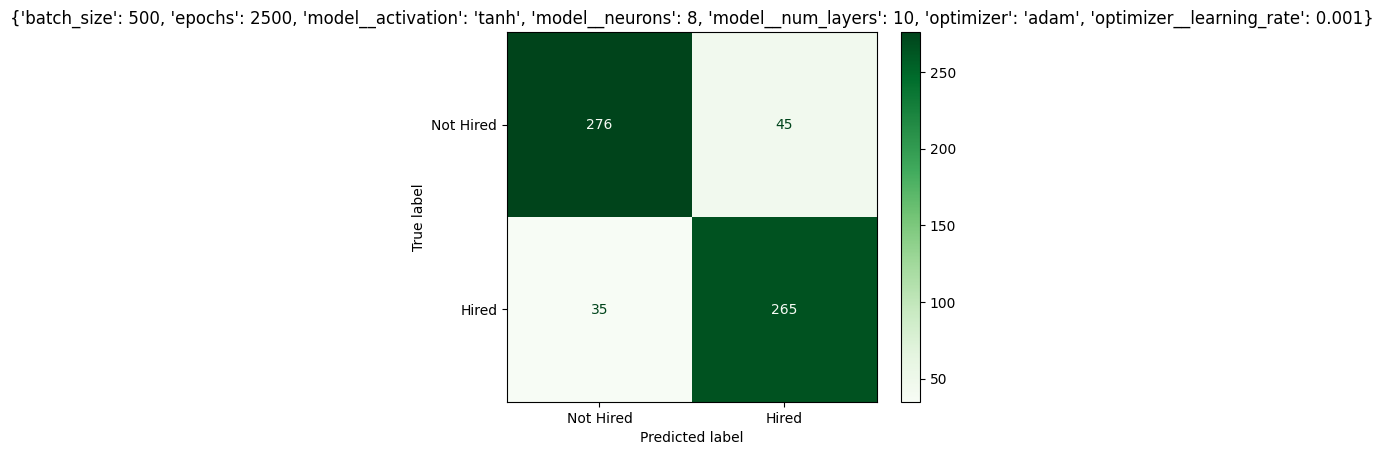

In [78]:
plt.plot(history.history_['loss'], label='Train')
plt.plot(history.history_['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history_['accuracy'], label='Train')
plt.plot(history.history_['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate probability predictions
y_pred_proba = best_model.predict(X_test_scaled)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
y_predict = grid_result.best_estimator_.predict(X_test_scaled)
fig = ConfusionMatrixDisplay.from_predictions(y_test, y_predict , display_labels=['Not Hired', 'Hired'], cmap='Greens')
plt.title(grid_result.best_params_)
plt.show()